###**Fake News Classification**

In [67]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

**Fetching Dataset**

In [3]:
!kaggle competitions download -c fake-news

100% 46.5M/46.5M [00:03<00:00, 19.3MB/s]
100% 46.5M/46.5M [00:03<00:00, 12.8MB/s]


In [4]:
import zipfile

zip_ref = zipfile.ZipFile('/content/fake-news.zip', 'r')
zip_ref.extractall('/content/')
zip_ref.close()

In [68]:
df=pd.read_csv('/content/train.csv')
df.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


In [69]:
df.shape

(20800, 5)

In [70]:
df.isnull().sum()

,0
id,0
title,558
author,1957
text,39
label,0


**Data Preprocessing**

In [71]:
df = df.dropna()
df = df.drop(columns=["id", "author"])

In [72]:
df['combined_text'] = df['title'] + ' ' + df['text']  # Combine title and text for better context

In [73]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

In [74]:

df['cleaned_text'] = df['combined_text'].apply(preprocess_text)

In [87]:
df.head()

,title,text,label,combined_text,cleaned_text
0,House Dem Aide: We Didn’t Even See Comey’s Let...,House Dem Aide: We Didn’t Even See Comey’s Let...,1,House Dem Aide: We Didn’t Even See Comey’s Let...,house dem aide didnt even see comeys letter ja...
1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Ever get the feeling your life circles the rou...,0,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",flynn hillary clinton big woman campus breitba...
2,Why the Truth Might Get You Fired,"Why the Truth Might Get You Fired October 29, ...",1,Why the Truth Might Get You Fired Why the Trut...,truth might get fired truth might get fired oc...
3,15 Civilians Killed In Single US Airstrike Hav...,Videos 15 Civilians Killed In Single US Airstr...,1,15 Civilians Killed In Single US Airstrike Hav...,civilians killed single us airstrike identifie...
4,Iranian woman jailed for fictional unpublished...,Print \nAn Iranian woman has been sentenced to...,1,Iranian woman jailed for fictional unpublished...,iranian woman jailed fictional unpublished sto...


**Data Spliting**

In [75]:
X = df['cleaned_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


**Tokenization**

In [76]:
max_words = 10000  # Reduced vocabulary size for efficiency
max_len = 256     # Maximum sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

In [77]:
# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

**Padding**

In [78]:
X_train_pad = pad_sequences(train_sequences, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(test_sequences, maxlen=max_len, padding='post', truncating='post')


**Applying GLOVE**

In [80]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2025-02-07 21:42:09--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-02-07 21:42:09--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-02-07 21:42:10--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [81]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


**Creating Embeddings**

In [82]:
# embedding matrix (using GloVe embeddings)
embedding_dim = 100
embeddings_index = {}
with open('glove.6B.100d.txt') as f:  # Download from https://nlp.stanford.edu/projects/glove/
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

**Model Building**

In [83]:
model = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              input_length=max_len,
              weights=[embedding_matrix],
              trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.5),
    Bidirectional(LSTM(32)),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [88]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 256, 100)            │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 256, 128)            │          84,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,389,765 (5.30 MB)

 Trainable params: 129,921 (507.50 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

 Optimizer params: 259,844 (1015.02 KB)

In [84]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


**Model Training**

In [85]:
history = model.fit(X_train_pad, y_train,
                    epochs=10,
                    batch_size=64,
                    validation_data=(X_test_pad, y_test),
                    verbose=1)

Epoch 1/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - accuracy: 0.7639 - loss: 0.4463 - val_accuracy: 0.9308 - val_loss: 0.1580
Epoch 2/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 16s 46ms/step - accuracy: 0.9483 - loss: 0.1387 - val_accuracy: 0.9530 - val_loss: 0.1299
Epoch 3/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - accuracy: 0.9651 - loss: 0.0963 - val_accuracy: 0.9445 - val_loss: 0.1355
Epoch 4/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 19s 42ms/step - accuracy: 0.9612 - loss: 0.1004 - val_accuracy: 0.9636 - val_loss: 0.1064
Epoch 5/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9765 - loss: 0.0670 - val_accuracy: 0.9601 - val_loss: 0.1179
Epoch 6/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.9790 - loss: 0.0617 - val_accuracy: 0.9653 - val_loss: 0.0975
Epoch 7/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 22s 65ms/step - accuracy: 0.9825 - loss: 0.0496 - val_accuracy: 0.9680 - val_loss: 0.0979
Epoch 8/10
229/229 ━━━━━━━━━━━━━━━━━━━━ 16s 45ms/step - accuracy: 0.9855 - loss: 0.0388 - 

**Evaluatation**

In [86]:
loss, accuracy = model.evaluate(X_test_pad, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.9643 - loss: 0.1195
Test Accuracy: 96.58%


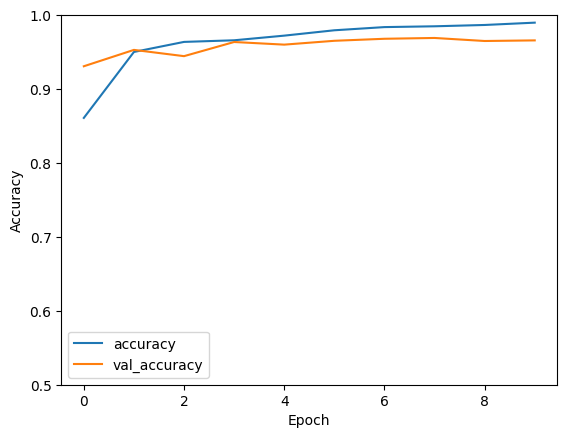

In [89]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend()